In [17]:
import jsonlines
import numpy as np
import pandas as pd
from collections import defaultdict

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.family'] = 'DeJavu Serif'

### Ablation: Style & Size

In [18]:
metrics, aspects = ['ASR', 'LC_WR'], ['Safety', 'Utility']
metric2results = {m:pd.read_json(f'Data/{a}/_scoreboard_.jsonl', lines=True) for m,a in zip(metrics, aspects)}

get_row = lambda results, train: results[(results['base']==model) & (results['train']==train)].iloc[0]
get_score = lambda row, style_utility, metric: row[f'{style_utility} {metric.lower()}']

model, size_utility = 'Llama3.1-8B', 10000
metric2style2change_list, metric2style2change_poem, metric2size2change_list = defaultdict(dict), defaultdict(dict), defaultdict(dict)
for metric in metrics:
    results = metric2results[metric]
    base_row = get_row(results, 'base')
    
    styles_utility = ['list', 'poem']
    for style_utility, metric2style2change in zip(styles_utility, [metric2style2change_list, metric2style2change_poem]):
        base_score = get_score(base_row, style_utility, metric)
        styles_safety, size_safety = ['list', 'poem', 'shakespeare', 'code', 'original', 'simplified'], 50
        for style_safety in styles_safety:
            train_row = get_row(results, f'{style_utility}-{size_utility}-{style_safety}-{size_safety}')
            train_score = get_score(train_row, style_utility, metric)
            metric2style2change[metric][style_safety] = train_score - base_score
        
    style_utility, style_safety, sizes_safety = 'list', 'list', [0, 10, 50, 100, 500, 1000]
    base_score = get_score(base_row, style_utility, metric)
    for size_safety in sizes_safety:
        train_row = get_row(results, f'{style_utility}-{size_utility}-{style_safety}-{size_safety}' if size_safety else f'{style_utility}-{size_utility}')
        train_score = get_score(train_row, style_utility, metric)
        metric2size2change_list[metric][size_safety] = train_score - base_score    

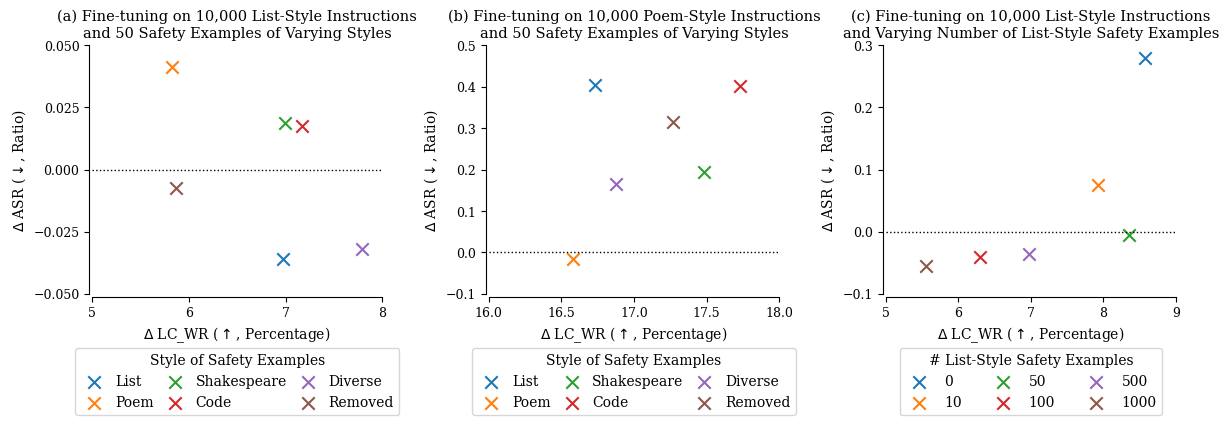

In [19]:
fontsize = 10
num_row, num_col = 1, 3
size_row, size_col = 4.55, 4
fig, axs = plt.subplots(num_row, num_col, figsize=(num_col*size_col, num_row*size_row))
metric_labels = [r'$\Delta$ ASR ($\downarrow$, Ratio)', r'$\Delta$ LC_WR ($\uparrow$, Percentage)']

################################################
styles_safety = ['List', 'Poem', 'Shakespeare', 'Code', 'Diverse', 'Removed']
colors_safety = sns.color_palette("tab10", len(styles_safety))
for kid, key in enumerate(metric2style2change_list['LC_WR']):
    axs[0].scatter(metric2style2change_list['LC_WR'][key], metric2style2change_list['ASR'][key], 
                   label=styles_safety[kid], marker='x', s=fontsize*8, color=colors_safety[kid])

sns.despine(ax=axs[0], offset=dict(left=2, bottom=2))
axs[0].set_yticks(np.linspace(-0.05, 0.05, 5))
axs[0].set_xticks(np.linspace(5, 8, 4))
axs[0].tick_params(axis='both', which='major', labelsize=fontsize-1)
axs[0].axhline(y=0, linestyle=':', color='black', linewidth=1)

axs[0].set_ylabel(metric_labels[0], fontsize=fontsize)
axs[0].set_xlabel(metric_labels[1], fontsize=fontsize)
axs[0].set_title('(a) Fine-tuning on 10,000 List-Style Instructions\nand 50 Safety Examples of Varying Styles', fontsize=fontsize+0.5)
axs[0].legend(fontsize=fontsize, ncol=3, columnspacing=0.5, handletextpad=0.5, bbox_to_anchor=(0.5,-0.19), loc='upper center',
              title='Style of Safety Examples', title_fontsize=fontsize)
################################################

################################################
styles_safety = ['List', 'Poem', 'Shakespeare', 'Code', 'Diverse', 'Removed']
colors_safety = sns.color_palette("tab10", len(styles_safety))
for kid, key in enumerate(metric2style2change_poem['LC_WR']):
    axs[1].scatter(metric2style2change_poem['LC_WR'][key], metric2style2change_poem['ASR'][key], 
                   label=styles_safety[kid], marker='x', s=fontsize*8, color=colors_safety[kid])

sns.despine(ax=axs[1], offset=dict(left=2, bottom=2))
axs[1].set_yticks(np.linspace(-0.1, 0.5, 7))
axs[1].set_xticks(np.linspace(16, 18, 5))
axs[1].tick_params(axis='both', which='major', labelsize=fontsize-1)
axs[1].axhline(y=0, linestyle=':', color='black', linewidth=1)

axs[1].set_ylabel(metric_labels[0], fontsize=fontsize)
axs[1].set_xlabel(metric_labels[1], fontsize=fontsize)
axs[1].set_title('(b) Fine-tuning on 10,000 Poem-Style Instructions\nand 50 Safety Examples of Varying Styles', fontsize=fontsize+0.5)
axs[1].legend(fontsize=fontsize, ncol=3, columnspacing=0.5, handletextpad=0.5, bbox_to_anchor=(0.5,-0.19), loc='upper center', 
              title='Style of Safety Examples', title_fontsize=fontsize)
################################################

################################################
sizes_safety = [0, 10, 50, 100, 500, 1000]
colors_safety = sns.color_palette("tab10", len(sizes_safety))
for kid, key in enumerate(metric2size2change_list['ASR']):
    axs[2].scatter(metric2size2change_list['LC_WR'][key], metric2size2change_list['ASR'][key], 
                   label=sizes_safety[kid], marker='x', s=fontsize*8, color=colors_safety[kid])

sns.despine(ax=axs[2], offset=dict(left=2, bottom=2))
axs[2].set_yticks(np.linspace(-0.1, 0.3, 5))
axs[2].set_xticks(np.linspace(5, 9, 5))
axs[2].tick_params(axis='both', which='major', labelsize=fontsize-1)
axs[2].axhline(y=0, linestyle=':', color='black', linewidth=1)

axs[2].set_ylabel(metric_labels[0], fontsize=fontsize)
axs[2].set_xlabel(metric_labels[1], fontsize=fontsize)
axs[2].set_title('(c) Fine-tuning on 10,000 List-Style Instructions\nand Varying Number of List-Style Safety Examples', fontsize=fontsize+0.5)
axs[2].legend(fontsize=fontsize, ncol=3, bbox_to_anchor=(0.5,-0.19), loc='upper center', 
              title='# List-Style Safety Examples', title_fontsize=fontsize)
################################################

plt.tight_layout()
plt.savefig('Figure/ablation.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

### Results

In [101]:
metrics, aspects = ['ASR', 'LC_WR'], ['Safety', 'Utility']
metric2results = {m:pd.read_json(f'Data/{a}/_scoreboard_.jsonl', lines=True) for m,a in zip(metrics, aspects)}

get_row = lambda results, model, train: results[(results['base']==model) & (results['train']==train)].iloc[0]
get_score = lambda row, style_utility, metric: row[f'{style_utility} {metric.lower()}'] if style_utility!='mix' else row[[f'{s} {metric.lower()}' for s in styles_utility[:-1]]].mean()

def get_baseline_row(results, model, baseline, style_utility):
    if baseline == 'no defense': return get_row(results, model, f'{style_utility}-{size_utility}')
    elif baseline == 'vanilla': return get_row(results, model, f'{style_utility}-{size_utility}-original-{size_safety}')
    elif baseline == 'ptst': return get_row(results, model, f'{style_utility}-{size_utility}-ptst')    
    elif baseline == 'sppft': return get_row(results, model, f'{style_utility}-{size_utility}-sppft')
    elif baseline == 'constrained': return get_row(results, model, f'{style_utility}-{size_utility}-constrained')
    elif baseline == 'paraphrase': return get_row(results, model, f'{style_utility}-{size_utility}-paraphrase-{size_safety}')
    elif baseline == 'safestyle': return get_row(results, model, f'{style_utility}-{size_utility}-{style_utility}-{size_safety}')

size_utility, size_safety = 10000, 50
styles_utility = ['list', 'poem', 'shakespeare', 'code', 'mix']
baselines = {'Llama3.1-8B':['no defense', 'vanilla', 'ptst', 'sppft', 'constrained', 'paraphrase', 'safestyle'], 
             'Gemma3-12B':['no defense', 'vanilla', 'ptst', 'sppft', 'constrained', 'paraphrase', 'safestyle'],
             'Qwen2.5-3B':['no defense', 'vanilla', 'ptst', 'sppft', 'constrained', 'paraphrase', 'safestyle']}
models = baselines.keys()

model2metric2style2baseline2change = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
for model in models:
    for metric in metrics:
        results = metric2results[metric]
        base_row = get_row(results, model, 'base')

        for style_utility in styles_utility:
            base_score = get_score(base_row, style_utility, metric)
            for baseline in baselines[model]:
                baseline_row = get_baseline_row(results, model, baseline, style_utility)
                baseline_score = get_score(baseline_row, style_utility, metric)
                model2metric2style2baseline2change[model][metric][style_utility][baseline] = baseline_score - base_score